In [9]:
from trainer import Trainer 
import torch
import validate
from transformer.utils import subsequent_mask
import matplotlib.pyplot as plt
import seaborn
from dataset.iwslt import IWSLTDatasetBuilder
from transformer.model import Transformer
from logging import getLogger 

In [8]:
params_model = {
    'd_model': 512,
    'N': 6,
    'dropout': 0.1,
    'src_vocab_size': 46149,
    'tgt_vocab_size': 35385,

    'attention': {
        'n_head': 8,
        'd_k': 64,
        'd_v': 64,
        'dropout': 0.1},

    'feed-forward': {
        'd_ff': 2048,
        'dropout': 0.1
    }
}
model = Transformer(params_model)

In [10]:
logger = getLogger(name = 'loging_epoch14')
model.load('./experiments/IWSLT/model_epoch_14.pt', logger)

### Load model and vocabularies

In [22]:
max_length=40
params = {
    "training": {
        "epochs": 1,
        "train_batch_size": 1024,
        "valid_batch_size": 1024,
        "smoothing": 0.1,
        "save_intermediate": False,
        "multi_gpu": False,
        "load_trained_model": False,
        "trained_model_checkpoint": ""
    },

    "optim": {
        "lr": 0.,
        "betas": (0.9, 0.98),
        "eps": 1e-9,
        "factor": 1,
        "warmup": 2000

    },

    "dataset": {
        "max_seq_length": max_length,  # ~ 90% of the training set
        "min_freq": 2,
        "start_token": "<s>",
        "eos_token": "</s>",
        "pad_token": "<blank>"

    },

    "model": {
        'd_model': 512,
        'N': 6,
        'dropout': 0.1,

        'attention': {
            'n_head': 8,
            'd_k': 64,
            'd_v': 64,
            'dropout': 0.1},

        'feed-forward': {
            'd_ff': 2048,
            'dropout': 0.1}
    }
}
trainer_ = Trainer(params)

[2019-04-22 17:44:27] - INFO - Trainer >>> Folder experiments/IWSLT/20190422_174427/ created.
[2019-04-22 17:44:27] - INFO - Trainer >>> Log File experiments/IWSLT/20190422_174427/training.log created.
[2019-04-22 17:44:27] - INFO - Trainer >>> Model folder experiments/IWSLT/20190422_174427/models/ created.
[2019-04-22 17:44:27] - INFO - Trainer >>> Configuration saved to experiments/IWSLT/20190422_174427/params.json.
[2019-04-22 17:44:27] - INFO - root >>> Failed to import cuda module: No module named 'caffe2.python.caffe2_pybind11_state_gpu'
[2019-04-22 17:44:27] - INFO - root >>> Failed to import AMD hip module: No module named 'caffe2.python.caffe2_pybind11_state_hip'
[2019-04-22 17:44:27] - WARNING - root >>> This caffe2 python run does not have GPU support. Will run in CPU only mode.
[2019-04-22 17:44:27] - INFO - Trainer >>> Creating the training & validation dataset, may take some time...
[2019-04-22 17:45:47] - INFO - Trainer >>> Created a training & a validation dataset, with

In [26]:
_, src_vocab, trg_vocab = trainer_.model, trainer_.src_vocab, trainer_.trg_vocab

In [206]:
### training
word = 0
batch = next(IWSLTDatasetBuilder.masked(IWSLTDatasetBuilder.transposed(
                        trainer_.training_dataset_iterator)))
src_, trg_ = batch.src[0], batch.trg[0]

In [222]:
### validation 
word = 0
batch = next(IWSLTDatasetBuilder.masked(IWSLTDatasetBuilder.transposed(
                        trainer_.validation_dataset_iterator)))
src_, trg_ = batch.src[0], batch.trg[0]

In [261]:
source = [src_vocab.itos[token] for token in src_] # french version
target = [trg_vocab.itos[token] for token in trg_] # english version
print(f'Source French sentence:\n {source}')
print(f'\nTarget English sentence:\n{target}')

Source French sentence:
 ['Personne', 'n', "'", 'a', 'lancé', 'une', 'entreprise', 'tout', 'seul', '.', 'Personne', '.', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>']

Target English sentence:
['<s>', 'Nobody', 'started', 'a', 'company', 'alone', '.', 'No', 'one', '.', '</s>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>']


In [262]:
### test outlier
source_eric = 'Il est évident que vous rêveriez de charettes avec un gros Filet .'.split()

#### Greedy Decoder

In [263]:
model.eval()
start_symbol ="<s>"
stop_symbol="</s>"
blank_symbol = "<blank>"

sent = source
src = torch.LongTensor([[src_vocab.stoi[w] for w in sent]])
src_mask = (src != src_vocab.stoi[blank_symbol]).unsqueeze(-2)

In [264]:
# 1. Embedding src
embedded = model.src_embeddings(src.type(torch.LongTensor))
embedded.shape

torch.Size([1, 40, 512])

In [265]:
# 2. Encode embedded inputs
memory = model.encoder(src=embedded, mask=src_mask)
memory.shape

torch.Size([1, 40, 512])

In [266]:
# 3. Create initial input for decoder
decoder_in = torch.ones(src.shape[0], 1).type(torch.FloatTensor) * trg_vocab.stoi[start_symbol]
decoder_in

tensor([[2.]])

In [269]:
sent_length = len(src_mask[src_mask>0])
sent_length

12

In [270]:
logits = []
## decode each word one by one considering previous output
for i in range(max_length):
    # 4. Embed decoder_in
    decoder_in_embed = model.trg_embeddings(decoder_in.type(torch.LongTensor))

    # 5. Go through decoder
    out = model.decoder(x=decoder_in_embed, memory=memory,
                       self_mask=subsequent_mask(decoder_in.shape[1]),
                       memory_mask=src_mask)

    # 6. classifier: TODO: Why only last word?
    logits.append(model.classifier(out[:, -1]))

    # 7. Get predicted token for each sample in the batch
    _, next_token = logits[-1].max(dim=1, keepdim=True)
    # 8. Concatenate predicted token with previous predictions
    decoder_in = torch.cat([decoder_in, next_token.type(torch.FloatTensor)], dim=1)

In [271]:
# cast to int tensors
decoder_integer = decoder_in.type(torch.IntTensor)

In [272]:
# 9. retrieve words from tokens in the target vocab
translation = ""
for i in range( decoder_integer.shape[1]):
    sym = trg_vocab.itos[decoder_integer[0, i]]
    translation += sym + " "
    if int(decoder_integer[0, i].data) == trg_vocab.stoi[stop_symbol]:
        break

# 10. return prediction
translation

'<s> There was no such a new way to get the police . </s> '

In [273]:
trgt_lenght = len(translation.split())

### Access the attention on encoder layer

In [274]:
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

In [275]:
n_head = 8
layer = 0
h = 1
model.encoder.layers[layer].self_attention.attention.attention_weights[0, h].shape

torch.Size([40, 40])

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of source with respect to source

Encoder stack 1


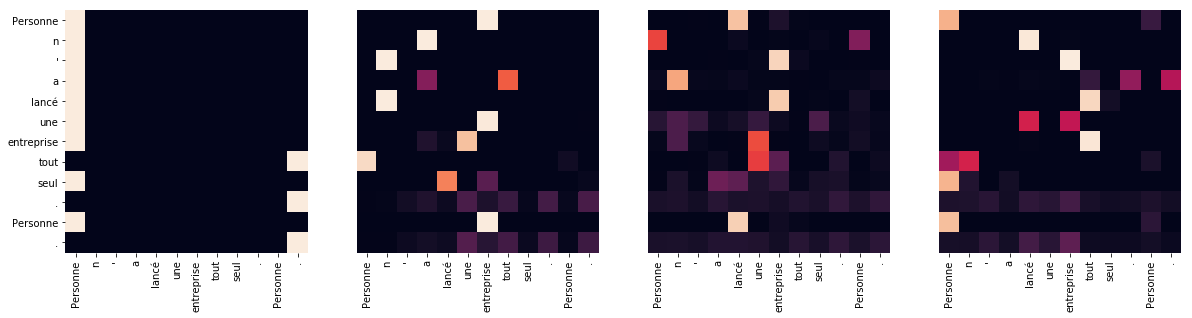

Encoder stack 2


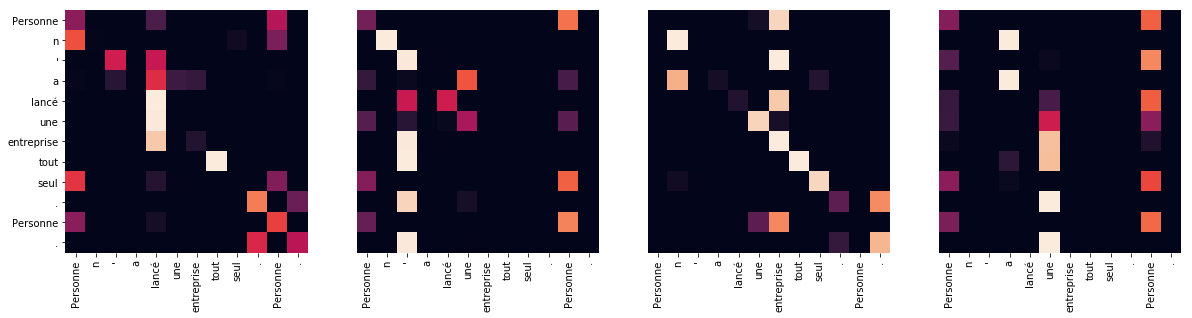

Encoder stack 3


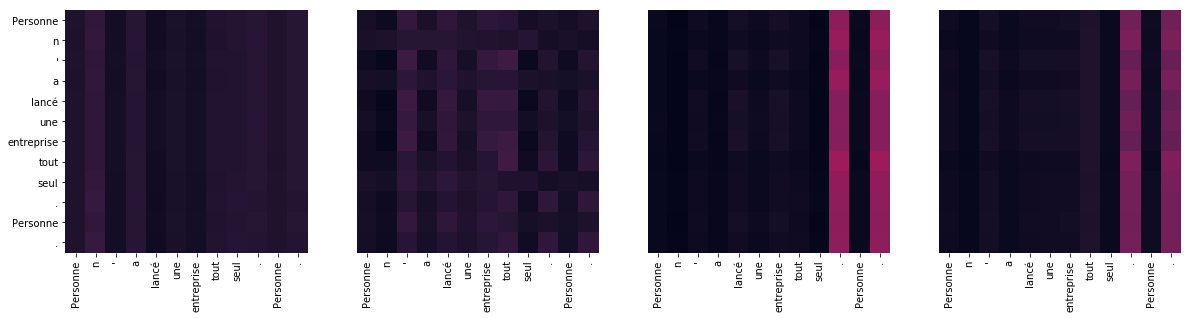

Encoder stack 4


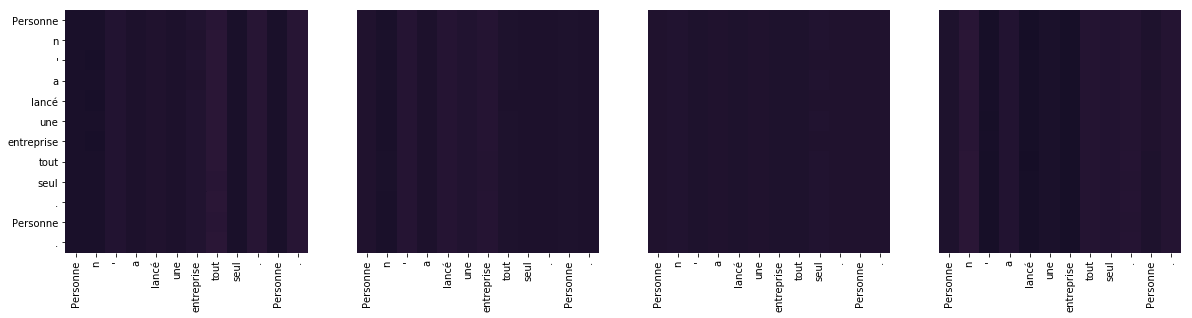

Encoder stack 5


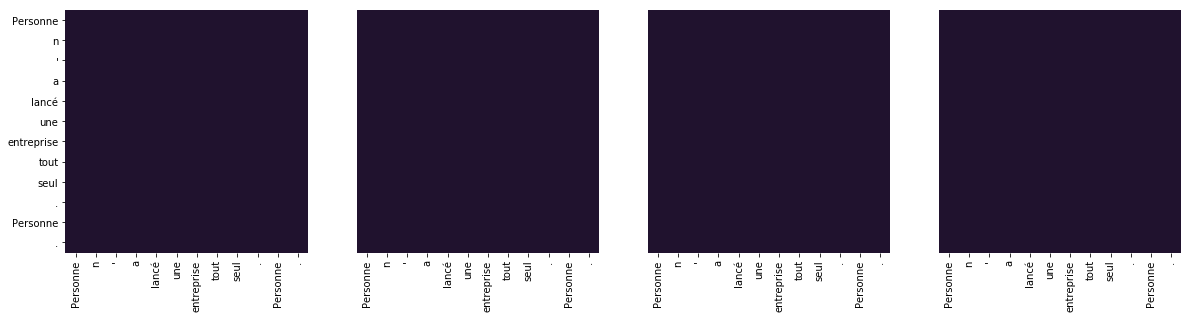

Encoder stack 6


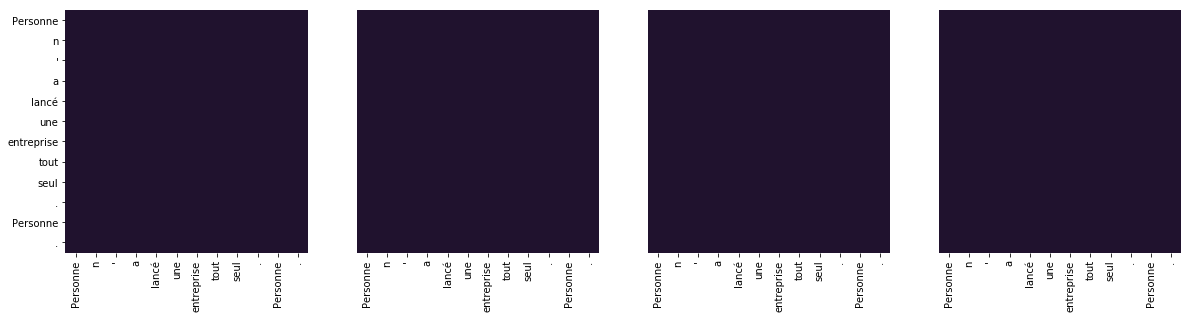

In [276]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Encoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.encoder.layers[layer].self_attention.attention.attention_weights[0, h, :sent_length, :sent_length].data, 
            sent[:sent_length], sent[:sent_length] if h ==0 else [], ax=axs[h])
    plt.show()

### Access the attention on decoder layer

In [277]:
model.decoder.layers[0].memory_attn.attention.attention_weights.shape

torch.Size([1, 8, 40, 40])

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of source with respect to target

In [278]:
model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h].shape

torch.Size([40, 40])

Decoder stack 1


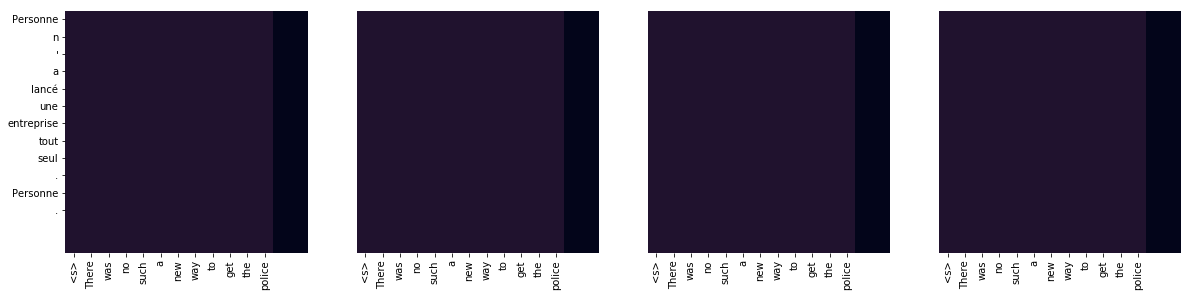

Decoder stack 2


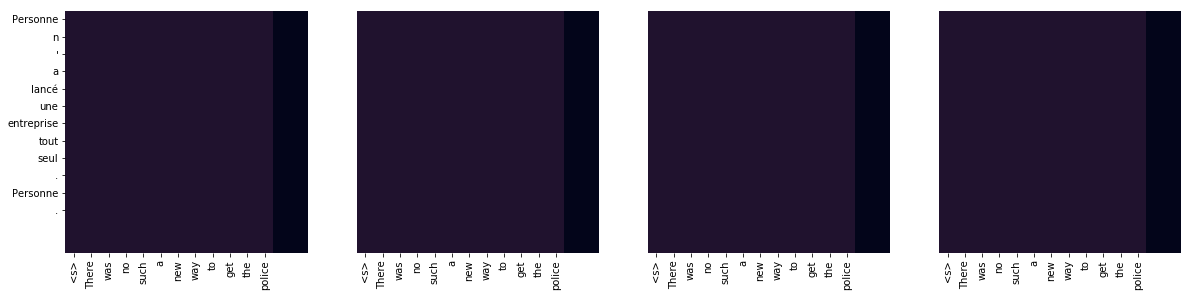

Decoder stack 3


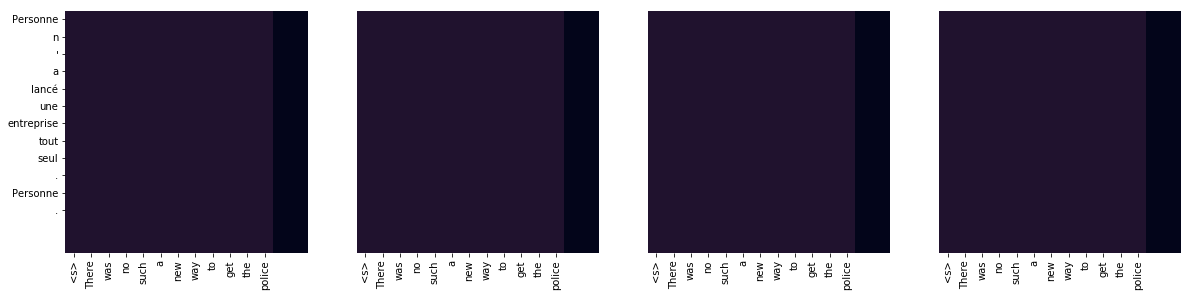

Decoder stack 4


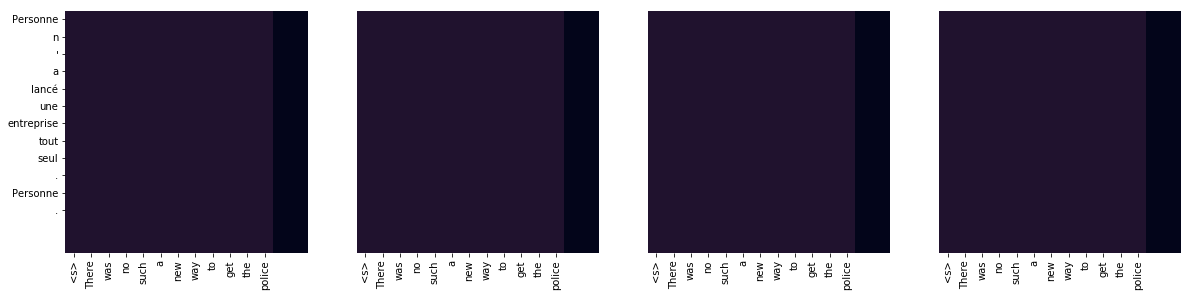

Decoder stack 5


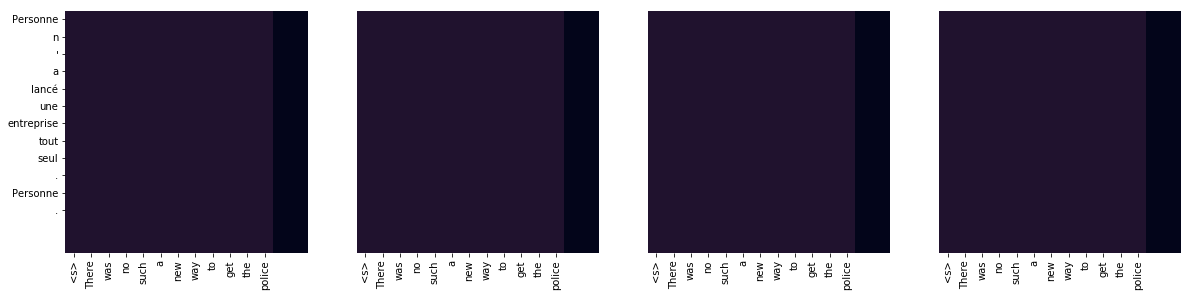

Decoder stack 6


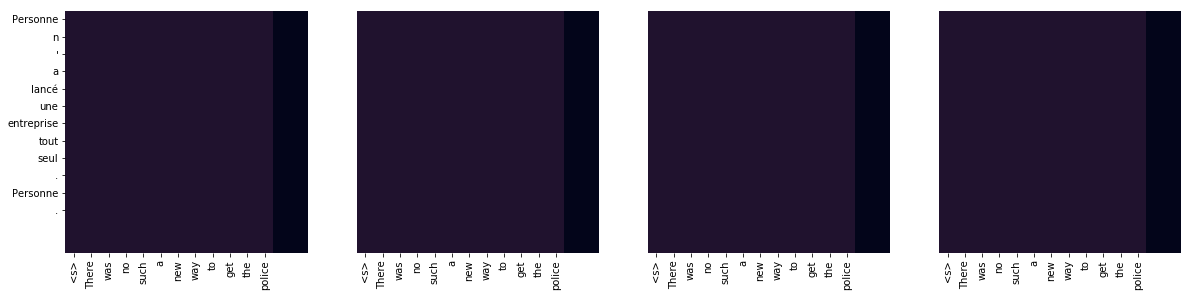

In [279]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h, :trgt_lenght, :trgt_lenght].data, 
            x=translation.split()[:sent_length], y=sent[:sent_length] if h ==0 else [], ax=axs[h])
    plt.show()

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of target with respect to target

In [280]:
model.decoder.layers[layer].self_attn.attention.attention_weights[0, h].shape

torch.Size([40, 40])

Decoder stack 1


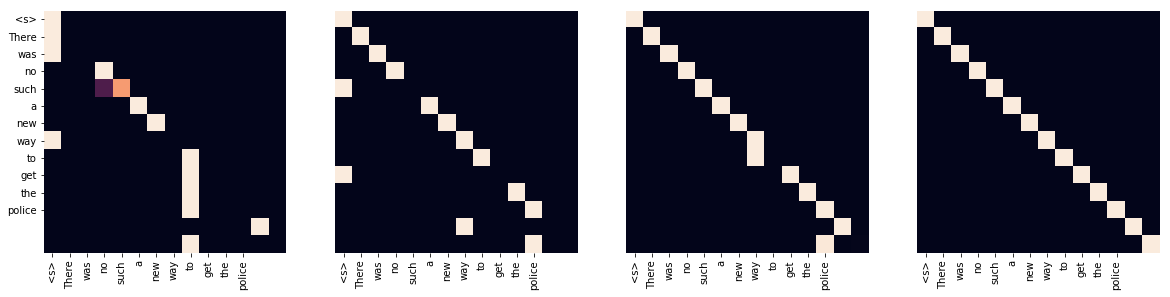

Decoder stack 2


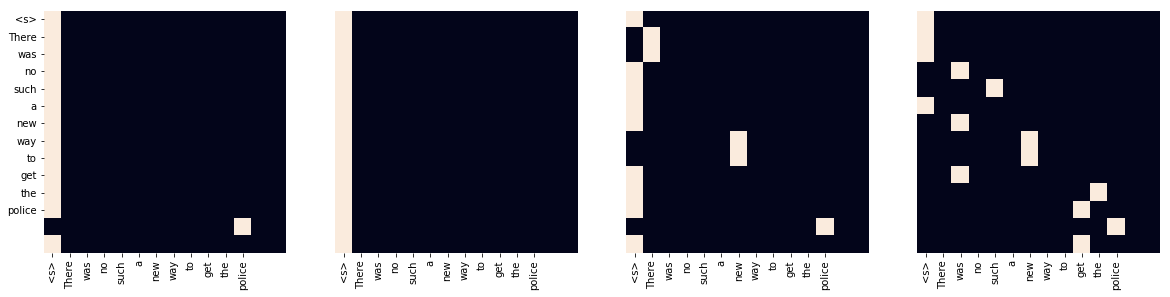

Decoder stack 3


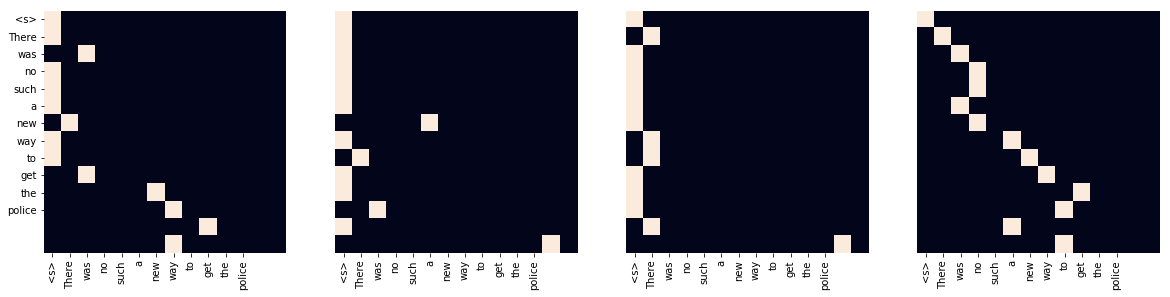

Decoder stack 4


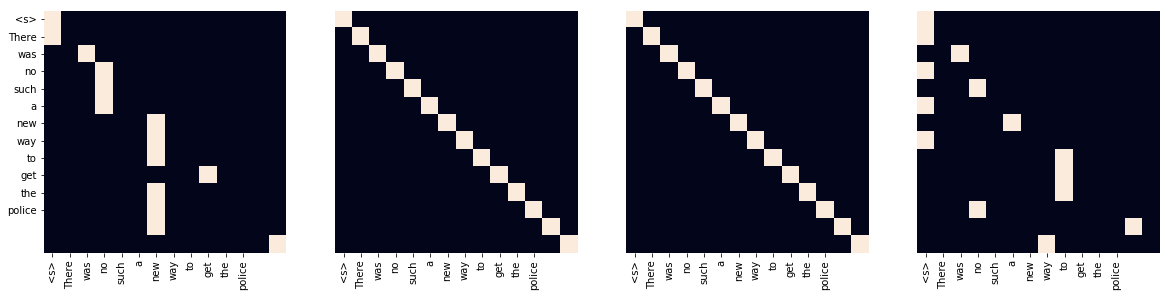

Decoder stack 5


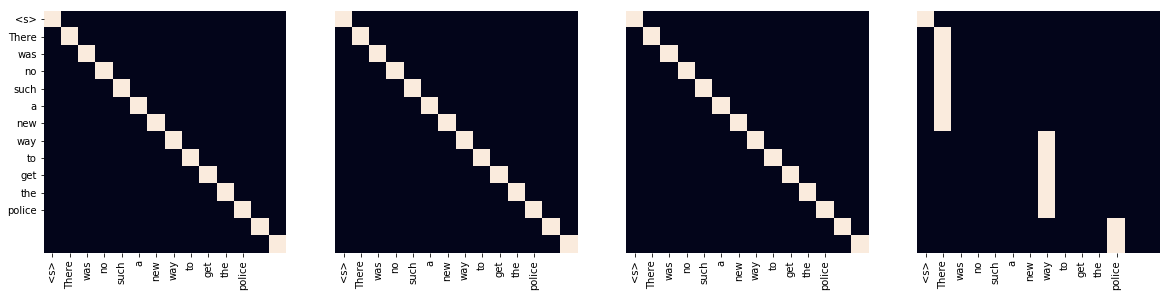

Decoder stack 6


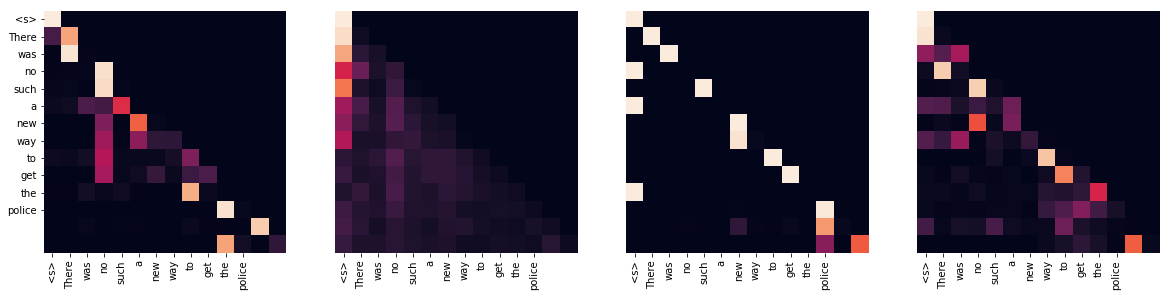

In [281]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.decoder.layers[layer].self_attn.attention.attention_weights[0, h, :trgt_lenght, :trgt_lenght].data, 
            x=translation.split()[:sent_length], y=translation.split()[:sent_length] if h ==0 else [], ax=axs[h])
    plt.show()

#### Prepare the json file for netviz

In [282]:
model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h].data.numpy().shape
len(target)

41

In [295]:
for i in range(len(translation.split())):
    print(i, translation.split()[i], len(translation) - 2)
    json_src = {
    "text": source,
    "label": target[i],
    "prediction": translation.split()[i],
    "posterior": list(logits[1].view(-1).data.numpy()),
    "attention": list(model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h, i].data.numpy()),
    "id": "sample_55"
  }

0 <s> 55
1 There 55
2 was 55
3 no 55
4 such 55
5 a 55
6 new 55
7 way 55
8 to 55
9 get 55
10 the 55
11 police 55
12 . 55
13 </s> 55


In [293]:
len(translation.split())

14